In [444]:
%load_ext autoreload
%autoreload 2

from IPython.display import display, HTML, clear_output
display(HTML("<style>.container { width:100% !important; }</style>"))

from importlib import reload
import logging
reload(logging)
import logging
logging.basicConfig(level=logging.INFO)

import glob
import numpy as np
import datetime
import json
import os
import os.path
from os.path import join
import warnings
import flatdict
import pandas as pd
import itertools
import mlflow
import gc
import plotly.graph_objects as go
import functools
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px
import plotly.colors
import plotly.offline as pyo
import itertools as it
from typing import List
import time
import copy
import cufflinks as cf


import utils as ut

from pprint import pprint, pformat
from tqdm.notebook import tqdm

from utils import ERA_COL, TARGET_COL


cf.go_offline()
pd.options.mode.chained_assignment = None  # default='warn'
# Filter the setuptools UserWarning until we stop relying on distutils
warnings.filterwarnings("ignore")
DF = pd.DataFrame
sns.set_theme()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [115]:
pyo.init_notebook_mode()

## 1. Constants

In [3]:
LOCAL = True
if LOCAL:
    ML_TRACKING_SERVER_URI = "http://127.0.0.1:5000"
    AWS_CREDENTIALS_FILE = "~/.aws/personal_credentials"
else:
    ML_TRACKING_SERVER_URI = "http://18.218.213.146:5500/"
    AWS_CREDENTIALS_FILE = "~/.aws/credentials"
EXPERIMENT_NAME = f"ensemble_tgts_for_cyrus_2023-04-26_19h-36m"
DATA_PATH = "./data/"
VAL_PRED_S3_PATH = (
    "s3://numerai-v1/experiments/"
    "ensemble_tgts_for_cyrus_2023-04-26_19h-36m/"
    "ckpt1_cv_val_preds_no_feats.pkl"
)
ENSEMBLE_MODELS_S3_PATH = (
    "s3://numerai-v1/experiments/"
    "ensemble_tgts_for_cyrus_2023-04-26_19h-36m/"
    "ensemble_models/"
)

log = ut.Logger(root_dir="./")

EXPT_LOCAL_DIR = os.path.join(DATA_PATH, "experiments", EXPERIMENT_NAME)
MODEL_DIR = join(EXPT_LOCAL_DIR, "models")
for fld in [EXPT_LOCAL_DIR, MODEL_DIR]:
    os.makedirs(fld, exist_ok=True)
    log.info(f"Making {fld}")
    
log.info(f"{EXPERIMENT_NAME=}")
log.info(f"{VAL_PRED_S3_PATH=}")

[2023-04-30 18:35:32]  Making ./data/experiments/ensemble_tgts_for_cyrus_2023-04-26_19h-36m
[2023-04-30 18:35:32]  Making ./data/experiments/ensemble_tgts_for_cyrus_2023-04-26_19h-36m/models
[2023-04-30 18:35:32]  EXPERIMENT_NAME='ensemble_tgts_for_cyrus_2023-04-26_19h-36m'
[2023-04-30 18:35:32]  VAL_PRED_S3_PATH='s3://numerai-v1/experiments/ensemble_tgts_for_cyrus_2023-04-26_19h-36m/ckpt1_cv_val_preds_no_feats.pkl'


In [4]:
log.info(f"{TARGET_COL=}")

[2023-04-30 18:35:32]  TARGET_COL='target_cyrus_v4_20'


## 2. Download data and load up the model predns on val data

In [5]:
# mlflow.set_tracking_uri(ML_TRACKING_SERVER_URI)
# try:
#     cv_expt_id = mlflow.create_experiment(name=EXPERIMENT_NAME)
# except Exception:
#     cv_expt_id = mlflow.get_experiment_by_name(name=EXPERIMENT_NAME).experiment_id
# log.info(f"{EXPERIMENT_NAME=}, {cv_expt_id=}")

In [6]:
ut.download_s3_file(
    local_path=EXPT_LOCAL_DIR,
    s3_path=VAL_PRED_S3_PATH,
    aws_credential_fl=AWS_CREDENTIALS_FILE,
)

[2023-04-30 18:35:32]  Loading aws credenitals from ~/.aws/personal_credentials...
[2023-04-30 18:35:32]  Would have downloaded s3://numerai-v1/experiments/ensemble_tgts_for_cyrus_2023-04-26_19h-36m/ckpt1_cv_val_preds_no_feats.pkl to ./data/experiments/ensemble_tgts_for_cyrus_2023-04-26_19h-36m/ckpt1_cv_val_preds_no_feats.pkl. But ./data/experiments/ensemble_tgts_for_cyrus_2023-04-26_19h-36m/ckpt1_cv_val_preds_no_feats.pkl exists. Will not download again ...


In [7]:
cv_valpreds_orig = ut.unpickle_obj(fl=join(EXPT_LOCAL_DIR, "ckpt1_cv_val_preds_no_feats.pkl"))

In [8]:
# HACK: Accidentally duplicated the columns twice, only include them once instead
NUM_TARGETS = 36
cv_valpreds = copy.deepcopy(cv_valpreds_orig)
cv_valpreds["cv_predcols_map"] = [
    cv_pc[:NUM_TARGETS]
    for cv_pc in cv_valpreds["cv_predcols_map"]
]

In [9]:
gc.collect()

23480

In [10]:
split = 0
cv_valpreds["cv_to_val_test_map"][split]["val"].head()

target  target_nomi_v4_20  target_nomi_v4_60   
id                                                               
n001f768affa1cc2     1.0                1.0               0.75  \
n002cc5b29f8705f     0.5                0.5               0.50   
n00361f031876c68     0.5                0.5               0.50   
n00385e672d049e6     0.0                0.0               0.25   
n00503d13b28d441     0.5                0.5               0.50   

                  target_tyler_v4_20  target_tyler_v4_60  target_victor_v4_20   
id                                                                              
n001f768affa1cc2                0.75                0.75                  1.0  \
n002cc5b29f8705f                0.25                0.50                  0.5   
n00361f031876c68                0.50                0.50                  0.5   
n00385e672d049e6                0.25                0.50                  0.0   
n00503d13b28d441                0.50                0.25                  0.5   

                  target_victor_v4_60  target_ralph_v4_20  target_ralph_v4_60   
id                                                                              
n001f768affa1cc2                 0.75                 1.0                0.75  \
n002cc5b29f8705f                 0.50                 0.5                0.50   
n00361f031876c68                 0.50                 0.5                0.50   
n00385e672d049e6                 0.25                 0.0                0.25   
n00503d13b28d441                 0.50                 0.5                0.50   

                  target_waldo_v4_20  ...  pred_target_ben_v4_20_cv0   
id                                    ...                              
n001f768affa1cc2                 1.0  ...                   0.493943  \
n002cc5b29f8705f                 0.5  ...                   0.495377   
n00361f031876c68                 0.5  ...                   0.488254   
n00385e672d049e6                 0.0  ...                   0.491807   
n00503d13b28d441                 0.5  ...                   0.524468   

                  pred_target_ben_v4_60_cv0  pred_target_alan_v4_20_cv0   
id                                                                        
n001f768affa1cc2                   0.475514                    0.494528  \
n002cc5b29f8705f                   0.509305                    0.496175   
n00361f031876c68                   0.486235                    0.493248   
n00385e672d049e6                   0.488826                    0.511420   
n00503d13b28d441                   0.498629                    0.533116   

                  pred_target_alan_v4_60_cv0  pred_target_paul_v4_20_cv0   
id                                                                         
n001f768affa1cc2                    0.478933                    0.454020  \
n002cc5b29f8705f                    0.490550                    0.474163   
n00361f031876c68                    0.480340                    0.482077   
n00385e672d049e6                    0.501787                    0.455790   
n00503d13b28d441                    0.521875                    0.532201   

                  pred_target_paul_v4_60_cv0  pred_target_george_v4_20_cv0   
id                                                                           
n001f768affa1cc2                    0.450485                      0.455395  \
n002cc5b29f8705f                    0.483902                      0.486066   
n00361f031876c68                    0.454602                      0.475474   
n00385e672d049e6                    0.444844                      0.475221   
n00503d13b28d441                    0.516652                      0.525540   

                  pred_target_george_v4_60_cv0  pred_target_william_v4_20_cv0   
id                                                                              
n001f768affa1cc2                      0.436630                       0.499045  \
n002cc5b29f8705f                      0.495735                   

In [11]:
cv_valpreds["cv_to_val_test_map"][split]["test"].head()

target  target_nomi_v4_20  target_nomi_v4_60   
id                                                               
n00164cb9c597154    1.00               1.00               0.50  \
n0028609fde88b03    1.00               1.00               0.75   
n002bfff507f118e    0.50               0.50               0.50   
n002d0d989a01142    0.75               0.75               0.50   
n00620b3b0a59ab1    0.75               0.75               0.50   

                  target_tyler_v4_20  target_tyler_v4_60  target_victor_v4_20   
id                                                                              
n00164cb9c597154                0.75                0.50                 1.00  \
n0028609fde88b03                0.75                0.50                 0.75   
n002bfff507f118e                0.50                0.25                 0.50   
n002d0d989a01142                0.75                0.50                 0.75   
n00620b3b0a59ab1                1.00                0.50                 0.75   

                  target_victor_v4_60  target_ralph_v4_20  target_ralph_v4_60   
id                                                                              
n00164cb9c597154                  0.5                1.00                 0.5  \
n0028609fde88b03                  0.5                0.75                 0.5   
n002bfff507f118e                  0.5                0.25                 0.5   
n002d0d989a01142                  0.5                0.75                 0.5   
n00620b3b0a59ab1                  0.5                0.50                 0.5   

                  target_waldo_v4_20  ...  pred_target_ben_v4_20_cv0   
id                                    ...                              
n00164cb9c597154                0.75  ...                   0.462140  \
n0028609fde88b03                1.00  ...                   0.525290   
n002bfff507f118e                0.25  ...                   0.496298   
n002d0d989a01142                0.75  ...                   0.501930   
n00620b3b0a59ab1                0.75  ...                   0.479739   

                  pred_target_ben_v4_60_cv0  pred_target_alan_v4_20_cv0   
id                                                                        
n00164cb9c597154                   0.453088                    0.488272  \
n0028609fde88b03                   0.538764                    0.500456   
n002bfff507f118e                   0.508979                    0.501143   
n002d0d989a01142                   0.506025                    0.514477   
n00620b3b0a59ab1                   0.485134                    0.504286   

                  pred_target_alan_v4_60_cv0  pred_target_paul_v4_20_cv0   
id                                                                         
n00164cb9c597154                    0.476812                    0.432102  \
n0028609fde88b03                    0.505370                    0.526002   
n002bfff507f118e                    0.494654                    0.529000   
n002d0d989a01142                    0.505899                    0.552279   
n00620b3b0a59ab1                    0.501196                    0.535674   

                  pred_target_paul_v4_60_cv0  pred_target_george_v4_20_cv0   
id                                                                           
n00164cb9c597154                    0.393445                      0.457779  \
n0028609fde88b03                    0.543837                      0.532270   
n002bfff507f118e                    0.535165                      0.514607   
n002d0d989a01142                    0.565865                      0.508856   
n00620b3b0a59ab1                    0.544112                      0.506822   

                  pred_target_george_v4_60_cv0  pred_target_william_v4_20_cv0   
id                                                                              
n00164cb9c597154                      0.419536                       0.475697  \
n0028609fde88b03                      0.560145                   

## 3. Compute baseline metrics which is simply taking the average

In [12]:
def extract_cols_like(all_cols, match_cols):
    return [
        col for col in all_cols
        if any(partial in col for partial in match_cols)
    ]

In [13]:
import re
def refmt_predcols(col):
    """Use regex to extract col name 
    pred_target_arthur_v4_20_cv1 -> pred_arthur_v4_20"""
    return re.search(r"pred_target_(\w+)_cv", col).group(1)

In [14]:
def score_baselines(
    cv_valpreds,
    predcols_subset=None,
    agg_fn=np.mean,
    baseline_name="",
):
    """
    :param predcols_subset: This could be a partial name like ['arthur_v4_20', 'nomi_v4_60']
    """
    cv = len(cv_valpreds["cv_predcols_map"])
    # xval metrics, xval ensemble columns, xval prediction value describe
    bl_cv_metrics, bl_cv_predcols, cv_pred_descs = [], [], []
    for split, predcols, val_test_map in tqdm(
        zip(
            range(cv),
            cv_valpreds["cv_predcols_map"],
            cv_valpreds["cv_to_val_test_map"],
        ),
        desc="CV split",
        total=cv,
    ):
        train_df, test_df = val_test_map["val"], val_test_map["test"]
        log.info(
            f"{split=}, {train_df[predcols].shape=}, {train_df.era.min()=}, "
            f"{train_df.era.max()=}, {train_df.era.nunique()=}",
        )
        log.info(
            f"{split=}, {test_df[predcols].shape=}, {test_df.era.min()=}, "
            f"{test_df.era.max()=}, {test_df.era.nunique()=}",
        )
        ensmbl_predcol = f"ensemble_{baseline_name}_cv{split}"
        if predcols_subset is None:
            chosen_fts = predcols
        else:
            chosen_fts = extract_cols_like(all_cols=predcols, match_cols=predcols_subset)
        log.info(f"Chosen {len(chosen_fts)} features: \n{chosen_fts}")
        test_df[ensmbl_predcol] = agg_fn(test_df[chosen_fts], axis=1)
        bl_cv_metrics.append(
            ut.validation_metrics(
                validation_data=test_df, pred_cols=[ensmbl_predcol], target_col=TARGET_COL
            ),
        )
        cv_pred_descs.append(test_df[ensmbl_predcol].describe())
    log.info("Prediction distribution")
    display(pd.concat(cv_pred_descs, axis=1))
    baseline_metrics = ut.to_cv_agg_df(bl_cv_metrics)
    display(ut.fmt_metrics_df(baseline_metrics))
    return baseline_metrics

### 3.1 Average all 36 target models

In [225]:
bl_allpred_mean_metrics = score_baselines(
    cv_valpreds=cv_valpreds,
    predcols_subset=None,
    agg_fn=np.mean,
    baseline_name="allpreds_mean",
)

CV split:   0%|          | 0/3 [00:00<?, ?it/s]

[2023-05-01 09:39:32]  split=0, train_df[predcols].shape=(587086, 36), train_df.era.min()=820, train_df.era.max()=935, train_df.era.nunique()=116
[2023-05-01 09:39:32]  split=0, test_df[predcols].shape=(590333, 36), test_df.era.min()=948, test_df.era.max()=1059, test_df.era.nunique()=112
[2023-05-01 09:39:32]  Chosen 36 features: 
['pred_target_arthur_v4_20_cv0', 'pred_target_arthur_v4_60_cv0', 'pred_target_thomas_v4_20_cv0', 'pred_target_thomas_v4_60_cv0', 'pred_target_cyrus_v4_20_cv0', 'pred_target_cyrus_v4_60_cv0', 'pred_target_caroline_v4_20_cv0', 'pred_target_caroline_v4_60_cv0', 'pred_target_sam_v4_20_cv0', 'pred_target_sam_v4_60_cv0', 'pred_target_xerxes_v4_20_cv0', 'pred_target_xerxes_v4_60_cv0', 'pred_target_nomi_v4_20_cv0', 'pred_target_nomi_v4_60_cv0', 'pred_target_tyler_v4_20_cv0', 'pred_target_tyler_v4_60_cv0', 'pred_target_victor_v4_20_cv0', 'pred_target_victor_v4_60_cv0', 'pred_target_ralph_v4_20_cv0', 'pred_target_ralph_v4_60_cv0', 'pred_target_waldo_v4_20_cv0', 'pred_t

ensemble_allpreds_mean_cv0  ensemble_allpreds_mean_cv1   
count               590333.000000               571414.000000  \
mean                     0.499084                    0.501019   
std                      0.016239                    0.018883   
min                      0.403835                    0.392828   
25%                      0.488993                    0.488816   
50%                      0.499610                    0.501000   
75%                      0.509779                    0.513161   
max                      0.573454                    0.602210   

       ensemble_allpreds_mean_cv2  
count               507469.000000  
mean                     0.499891  
std                      0.025984  
min                      0.361744  
25%                      0.483469  
50%                      0.499875  
75%                      0.516336  
max                      0.649094

In [226]:
len([c for c in cv_valpreds["cv_to_val_test_map"][0]["test"].columns if c.startswith("pred_target_")])

36

### 3.2 Average top 8 target models

In [ ]:
cyrus,ralph,sam,xerxes,caroline,waldo,nomi,tyler

In [227]:
bl_top8pred_mean_metrics = score_baselines(
    cv_valpreds=cv_valpreds,
    predcols_subset=[
    "pred_target_cyrus_v4_20",
    "pred_target_ralph_v4_20",
    "pred_target_sam_v4_20",
    "pred_target_xerxes_v4_20",
    "pred_target_caroline_v4_20",
    "pred_target_waldo_v4_20",
    "pred_target_nomi_v4_20",
    "pred_target_tyler_v4_20",
    ],
    agg_fn=np.mean,
    baseline_name="top8preds_mean",
)

CV split:   0%|          | 0/3 [00:00<?, ?it/s]

[2023-05-01 09:39:39]  split=0, train_df[predcols].shape=(587086, 36), train_df.era.min()=820, train_df.era.max()=935, train_df.era.nunique()=116
[2023-05-01 09:39:39]  split=0, test_df[predcols].shape=(590333, 36), test_df.era.min()=948, test_df.era.max()=1059, test_df.era.nunique()=112
[2023-05-01 09:39:39]  Chosen 8 features: 
['pred_target_cyrus_v4_20_cv0', 'pred_target_caroline_v4_20_cv0', 'pred_target_sam_v4_20_cv0', 'pred_target_xerxes_v4_20_cv0', 'pred_target_nomi_v4_20_cv0', 'pred_target_tyler_v4_20_cv0', 'pred_target_ralph_v4_20_cv0', 'pred_target_waldo_v4_20_cv0']
[2023-05-01 09:39:39]  split=1, train_df[predcols].shape=(571392, 36), train_df.era.min()=556, train_df.era.max()=671, train_df.era.nunique()=116
[2023-05-01 09:39:39]  split=1, test_df[predcols].shape=(571414, 36), test_df.era.min()=684, test_df.era.max()=795, test_df.era.nunique()=112
[2023-05-01 09:39:39]  Chosen 8 features: 
['pred_target_cyrus_v4_20_cv1', 'pred_target_caroline_v4_20_cv1', 'pred_target_sam_v4_2

ensemble_top8preds_mean_cv0  ensemble_top8preds_mean_cv1   
count                590333.000000                571414.000000  \
mean                      0.499296                     0.500676   
std                       0.015129                     0.017853   
min                       0.410754                     0.413525   
25%                       0.489624                     0.488847   
50%                       0.499210                     0.500145   
75%                       0.509048                     0.511997   
max                       0.574484                     0.608171   

       ensemble_top8preds_mean_cv2  
count                507469.000000  
mean                      0.500170  
std                       0.024679  
min                       0.355457  
25%                       0.484232  
50%                       0.499550  
75%                       0.515318  
max                       0.668130

### 3.3 Only cyrus

In [228]:
bl_cyrus_metrics = score_baselines(
    cv_valpreds=cv_valpreds,
    predcols_subset=[
    "pred_target_cyrus_v4_20",
    ],
    agg_fn=np.mean,
    baseline_name="cyrus_only",
)

CV split:   0%|          | 0/3 [00:00<?, ?it/s]

[2023-05-01 09:39:40]  split=0, train_df[predcols].shape=(587086, 36), train_df.era.min()=820, train_df.era.max()=935, train_df.era.nunique()=116
[2023-05-01 09:39:40]  split=0, test_df[predcols].shape=(590333, 36), test_df.era.min()=948, test_df.era.max()=1059, test_df.era.nunique()=112
[2023-05-01 09:39:40]  Chosen 1 features: 
['pred_target_cyrus_v4_20_cv0']
[2023-05-01 09:39:40]  split=1, train_df[predcols].shape=(571392, 36), train_df.era.min()=556, train_df.era.max()=671, train_df.era.nunique()=116
[2023-05-01 09:39:41]  split=1, test_df[predcols].shape=(571414, 36), test_df.era.min()=684, test_df.era.max()=795, test_df.era.nunique()=112
[2023-05-01 09:39:41]  Chosen 1 features: 
['pred_target_cyrus_v4_20_cv1']
[2023-05-01 09:39:41]  split=2, train_df[predcols].shape=(500976, 36), train_df.era.min()=292, train_df.era.max()=408, train_df.era.nunique()=117
[2023-05-01 09:39:41]  split=2, test_df[predcols].shape=(507469, 36), test_df.era.min()=421, test_df.era.max()=531, test_df.era

ensemble_cyrus_only_cv0  ensemble_cyrus_only_cv1   
count            590333.000000            571414.000000  \
mean                  0.499325                 0.500647   
std                   0.015416                 0.018196   
min                   0.399952                 0.391883   
25%                   0.489571                 0.488724   
50%                   0.499304                 0.500166   
75%                   0.509175                 0.512116   
max                   0.583978                 0.622373   

       ensemble_cyrus_only_cv2  
count            507469.000000  
mean                  0.499923  
std                   0.026042  
min                   0.340739  
25%                   0.483367  
50%                   0.499483  
75%                   0.515794  
max                   0.680007

In [229]:
ut.fmt_metrics_df(bl_cyrus_metrics.loc[["cv_mean"]], add_bar=False)

## 4.1 Build a matrix of feature,wt -> (corr, sharpe)

In [58]:
def pairwise_wtd_xval(
    cv_valpreds,
    predcols,
    wts: np.ndarray,
    verbose=1,
    skip_precomputed=False,
):
    """Cross validates the ensemble model.
    
    :param wts: shape (p,1)
    :param verbose: > 0 prints everything, -1 just coefficients and average cv perf
        and < -1, nothing.
    """
    cv = len(cv_valpreds["cv_predcols_map"])
    ensmbl_cv_metrics, cv_pred_descs = [], []
    verbose_pos = verbose > 0
    for split, val_test_map in enumerate(cv_valpreds["cv_to_val_test_map"]):
        # create a test set by combining validation and test
        test_df = pd.concat(
            [val_test_map["val"], val_test_map["test"]], axis=0
        )
        # create column name
        ensmbl_predcol = build_ensemble_col_nm(wts, predcols) + f"_cv{split}"
        chosen_cols = [col+f"_cv{split}" for col in predcols]
        if verbose_pos:
            log.info(
                f"{split=}, {chosen_cols=}, {test_df[chosen_cols].shape=}, {test_df.era.min()=}, "
                f"{test_df.era.max()=}, {test_df.era.nunique()=}",
            )
        if verbose_pos:
            log.info(f"Predicting column: {ensmbl_predcol}")
        # Do the actual scoring as X @ w
        test_df[ensmbl_predcol] = test_df[chosen_cols].values @ wts
        # We can compute metrics on the whole test set
        metrics_df = ut.validation_metrics(
            validation_data=test_df, pred_cols=[ensmbl_predcol], target_col=TARGET_COL
        )
        ensmbl_cv_metrics.append(metrics_df)
        cv_pred_descs.append(test_df[ensmbl_predcol].describe())
    if verbose_pos:
        log.info("Prediction distribution")
        display(pd.concat(cv_pred_descs, axis=1))
    cv_metrics = ut.to_cv_agg_df(ensmbl_cv_metrics)
    if verbose == -1 or verbose_pos:
        display(cv_metrics)
    return cv_metrics.loc["cv_mean"]


def build_ensemble_col_nm(wts, predcols):
    return (
        f"ensemble_wts_{'_'.join(str(w) for w in wts)}_{'_'.join(predcols)}"
    )

In [21]:
PREDCOL_PREFIXES = np.array(
    sorted(c[:-4]
           for c in cv_valpreds["cv_predcols_map"][0]
           if not c.startswith('pred_target_cyrus_v4_20')
          )
)
log.info(f"{len(PREDCOL_PREFIXES)=}\n{PREDCOL_PREFIXES=}")

[2023-04-30 18:35:40]  len(PREDCOL_PREFIXES)=35
PREDCOL_PREFIXES=array(['pred_target_alan_v4_20', 'pred_target_alan_v4_60',
       'pred_target_arthur_v4_20', 'pred_target_arthur_v4_60',
       'pred_target_ben_v4_20', 'pred_target_ben_v4_60',
       'pred_target_caroline_v4_20', 'pred_target_caroline_v4_60',
       'pred_target_cyrus_v4_60', 'pred_target_george_v4_20',
       'pred_target_george_v4_60', 'pred_target_janet_v4_20',
       'pred_target_janet_v4_60', 'pred_target_jerome_v4_20',
       'pred_target_jerome_v4_60', 'pred_target_nomi_v4_20',
       'pred_target_nomi_v4_60', 'pred_target_paul_v4_20',
       'pred_target_paul_v4_60', 'pred_target_ralph_v4_20',
       'pred_target_ralph_v4_60', 'pred_target_sam_v4_20',
       'pred_target_sam_v4_60', 'pred_target_thomas_v4_20',
       'pred_target_thomas_v4_60', 'pred_target_tyler_v4_20',
       'pred_target_tyler_v4_60', 'pred_target_victor_v4_20',
       'pred_target_victor_v4_60', 'pred_target_waldo_v4_20',
       'pred_targe

In [22]:
NUM_PCOLS = len(PREDCOL_PREFIXES)
PCOL_WTS = np.array([[0, 0.01, 0.1, 0.3, 0.4]]).T
NUM_WTS = PCOL_WTS.shape[0]
WTS = np.concatenate([PCOL_WTS, 1-PCOL_WTS], axis=1)
log.info(f"{NUM_WTS=}\nWTS=\n{WTS}")

[2023-04-30 18:35:40]  NUM_WTS=5
WTS=
[[0.   1.  ]
 [0.01 0.99]
 [0.1  0.9 ]
 [0.3  0.7 ]
 [0.4  0.6 ]]


In [23]:
sharpe_mat, corr_mat = np.empty((NUM_PCOLS, NUM_WTS)), np.empty((NUM_PCOLS, NUM_WTS))
sharpe_mat[:] = corr_mat[:] = np.NaN
verbose = -2
for i, paircol in tqdm(list(enumerate(PREDCOL_PREFIXES)), desc="Pred Col"):
    for j, wts in tqdm(list(enumerate(WTS)), desc="Each weight"):
        metrics = pairwise_wtd_xval(
            cv_valpreds=cv_valpreds,
            predcols=[paircol, "pred_target_cyrus_v4_20"],
            wts=wts.T,
            verbose=-2,
            skip_precomputed=True,
        )
        sharpe_mat[i, j] = metrics.loc["sharpe"]
        corr_mat[i, j] = metrics.loc["mean"]
        if verbose > 0:
            display(ut.fmt_metrics_df(metrics.to_frame().transpose(), add_bar=False))

Pred Col:   0%|          | 0/35 [00:00<?, ?it/s]

Each weight:   0%|          | 0/5 [00:00<?, ?it/s]

Each weight:   0%|          | 0/5 [00:00<?, ?it/s]

Each weight:   0%|          | 0/5 [00:00<?, ?it/s]

Each weight:   0%|          | 0/5 [00:00<?, ?it/s]

Each weight:   0%|          | 0/5 [00:00<?, ?it/s]

Each weight:   0%|          | 0/5 [00:00<?, ?it/s]

Each weight:   0%|          | 0/5 [00:00<?, ?it/s]

Each weight:   0%|          | 0/5 [00:00<?, ?it/s]

Each weight:   0%|          | 0/5 [00:00<?, ?it/s]

Each weight:   0%|          | 0/5 [00:00<?, ?it/s]

Each weight:   0%|          | 0/5 [00:00<?, ?it/s]

Each weight:   0%|          | 0/5 [00:00<?, ?it/s]

Each weight:   0%|          | 0/5 [00:00<?, ?it/s]

Each weight:   0%|          | 0/5 [00:00<?, ?it/s]

Each weight:   0%|          | 0/5 [00:00<?, ?it/s]

Each weight:   0%|          | 0/5 [00:00<?, ?it/s]

Each weight:   0%|          | 0/5 [00:00<?, ?it/s]

Each weight:   0%|          | 0/5 [00:00<?, ?it/s]

Each weight:   0%|          | 0/5 [00:00<?, ?it/s]

Each weight:   0%|          | 0/5 [00:00<?, ?it/s]

Each weight:   0%|          | 0/5 [00:00<?, ?it/s]

Each weight:   0%|          | 0/5 [00:00<?, ?it/s]

Each weight:   0%|          | 0/5 [00:00<?, ?it/s]

Each weight:   0%|          | 0/5 [00:00<?, ?it/s]

Each weight:   0%|          | 0/5 [00:00<?, ?it/s]

Each weight:   0%|          | 0/5 [00:00<?, ?it/s]

Each weight:   0%|          | 0/5 [00:00<?, ?it/s]

Each weight:   0%|          | 0/5 [00:00<?, ?it/s]

Each weight:   0%|          | 0/5 [00:00<?, ?it/s]

Each weight:   0%|          | 0/5 [00:00<?, ?it/s]

Each weight:   0%|          | 0/5 [00:00<?, ?it/s]

Each weight:   0%|          | 0/5 [00:00<?, ?it/s]

Each weight:   0%|          | 0/5 [00:00<?, ?it/s]

Each weight:   0%|          | 0/5 [00:00<?, ?it/s]

Each weight:   0%|          | 0/5 [00:00<?, ?it/s]

In [24]:
def heatmap_metrics(
    metric_mat: np.ndarray,
    xlabels,
    ylabels,
    metric_nm,
    xtitle,
    ytitle,
    figsize=(5, 4),
    fmt=".3f",
    ax=None,
    **hm_kwargs,
):
    """Using seaborn library plots a heatmap of the metric_mat 
    where the xlabels and ylabels are the corresponding label names.
    """
    sns.set()
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    ax = sns.heatmap(
        metric_mat,
        annot=True,
        fmt=fmt,
        xticklabels=xlabels,
        yticklabels=ylabels,
        ax=ax,
        cmap="RdBu_r",
        **hm_kwargs,
    )
    ax.set_xlabel(xtitle, fontsize=14)
    ax.set_ylabel(ytitle, fontsize=14)
    ax.set_title(metric_nm, fontsize=14)


In [25]:
metric_to_mat = {"sharpe": sharpe_mat, "corr2": corr_mat}
metric_diff_to_mat = {
    k: mat-mat[0,0]
    for k, mat in metric_to_mat.items()
}
metric_prop_diff_to_mat = {
    k: (mat-mat[0,0]) / mat[0,0]
    for k, mat in metric_to_mat.items()
}

In [26]:
PREDCOL_SHORTER_NAMES = np.array(
    sorted(ut.refmt_predcol(c)
           for c in cv_valpreds["cv_predcols_map"][0]
           if not c.startswith('pred_target_cyrus_v4_20')
          )
)

In [27]:
def plot_hmap(metric_to_mat):
    fig, axes = plt.subplots(2, 1, figsize=(10,20))
    for mat, ax, metric_nm, fmt in zip(
        metric_to_mat.values(),
        axes.flat,
        metric_to_mat.keys(),
        [".2%", ".2%"]
    ):
        # 3-0.3 wt which works best
        srt_ix = mat[:,3].argsort()[::-1]
        heatmap_metrics(
            metric_mat=mat[srt_ix,:],
            xlabels=WTS[:,0],
            ylabels=PREDCOL_SHORTER_NAMES[srt_ix],
            metric_nm=metric_nm,
            xtitle="weight",
            ytitle="predcol",
            ax=ax,
            fmt=fmt,
            # set the mid value of the colour bar to cyrus only model
            center=mat[:,0].mean(),
        )

    plt.tight_layout()
    plt.show()

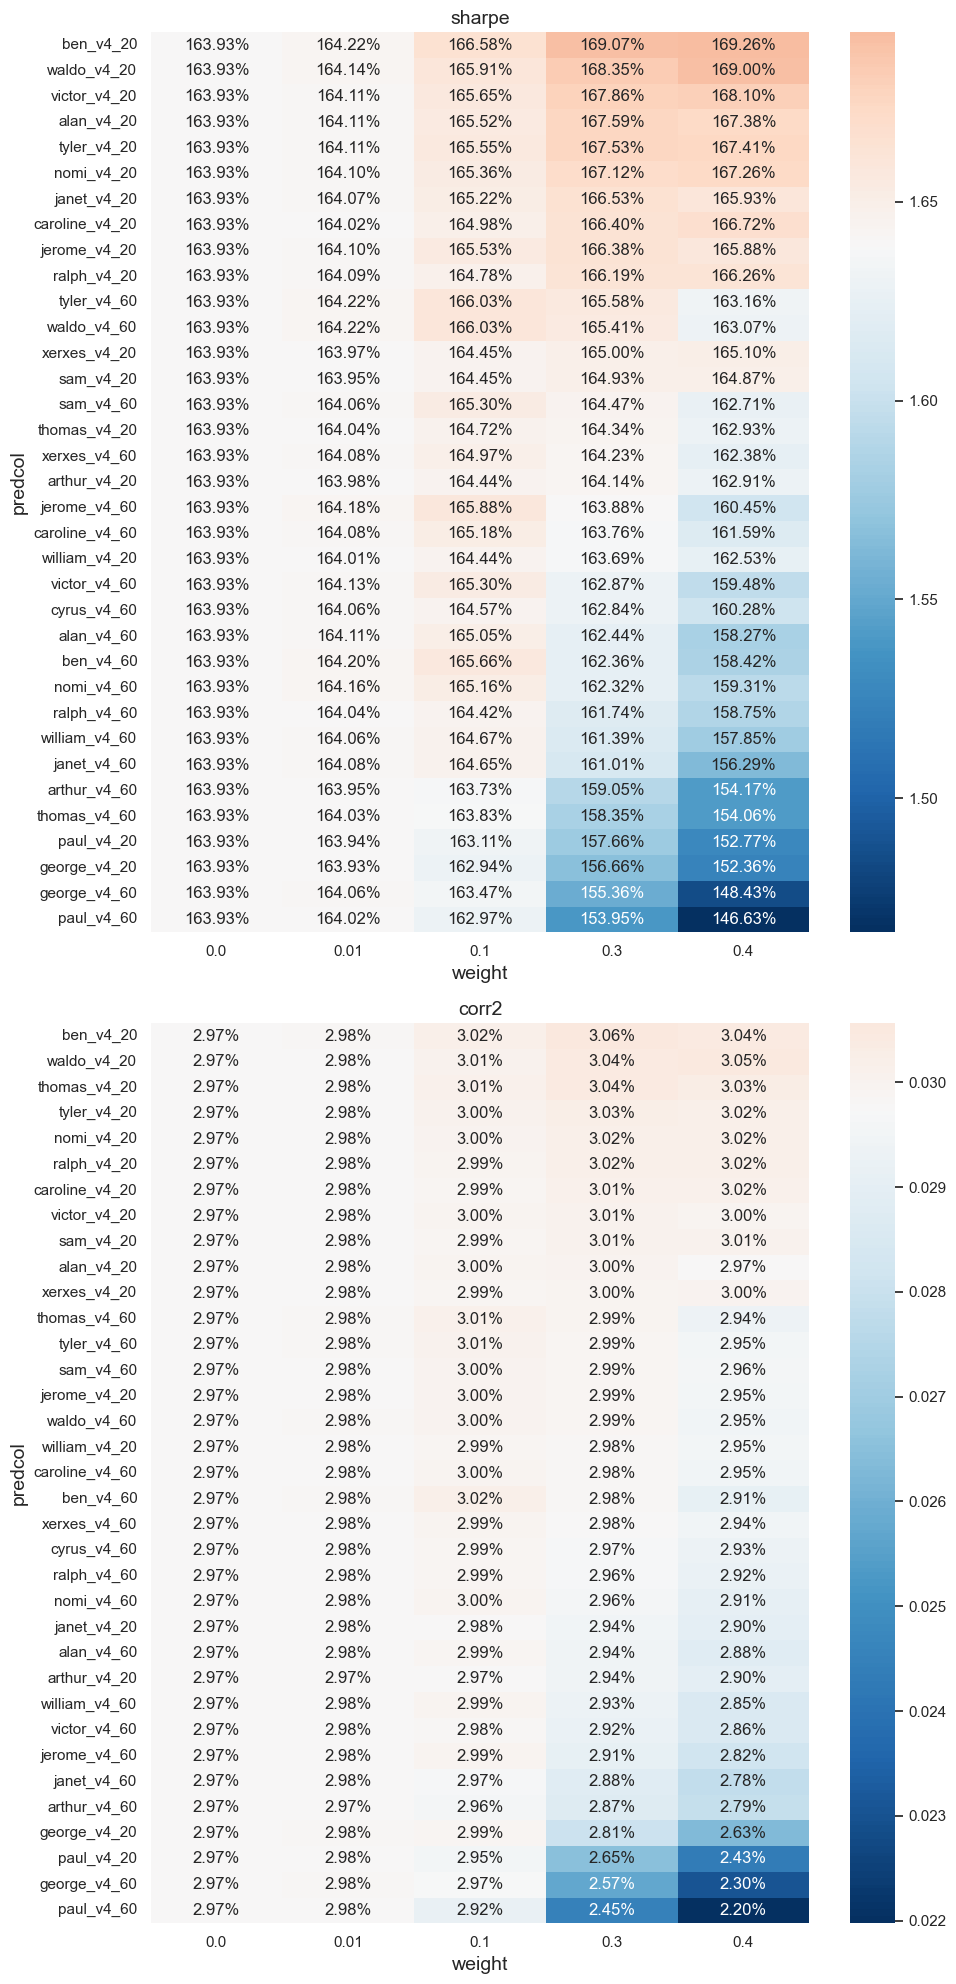

In [52]:
plot_hmap(metric_to_mat)

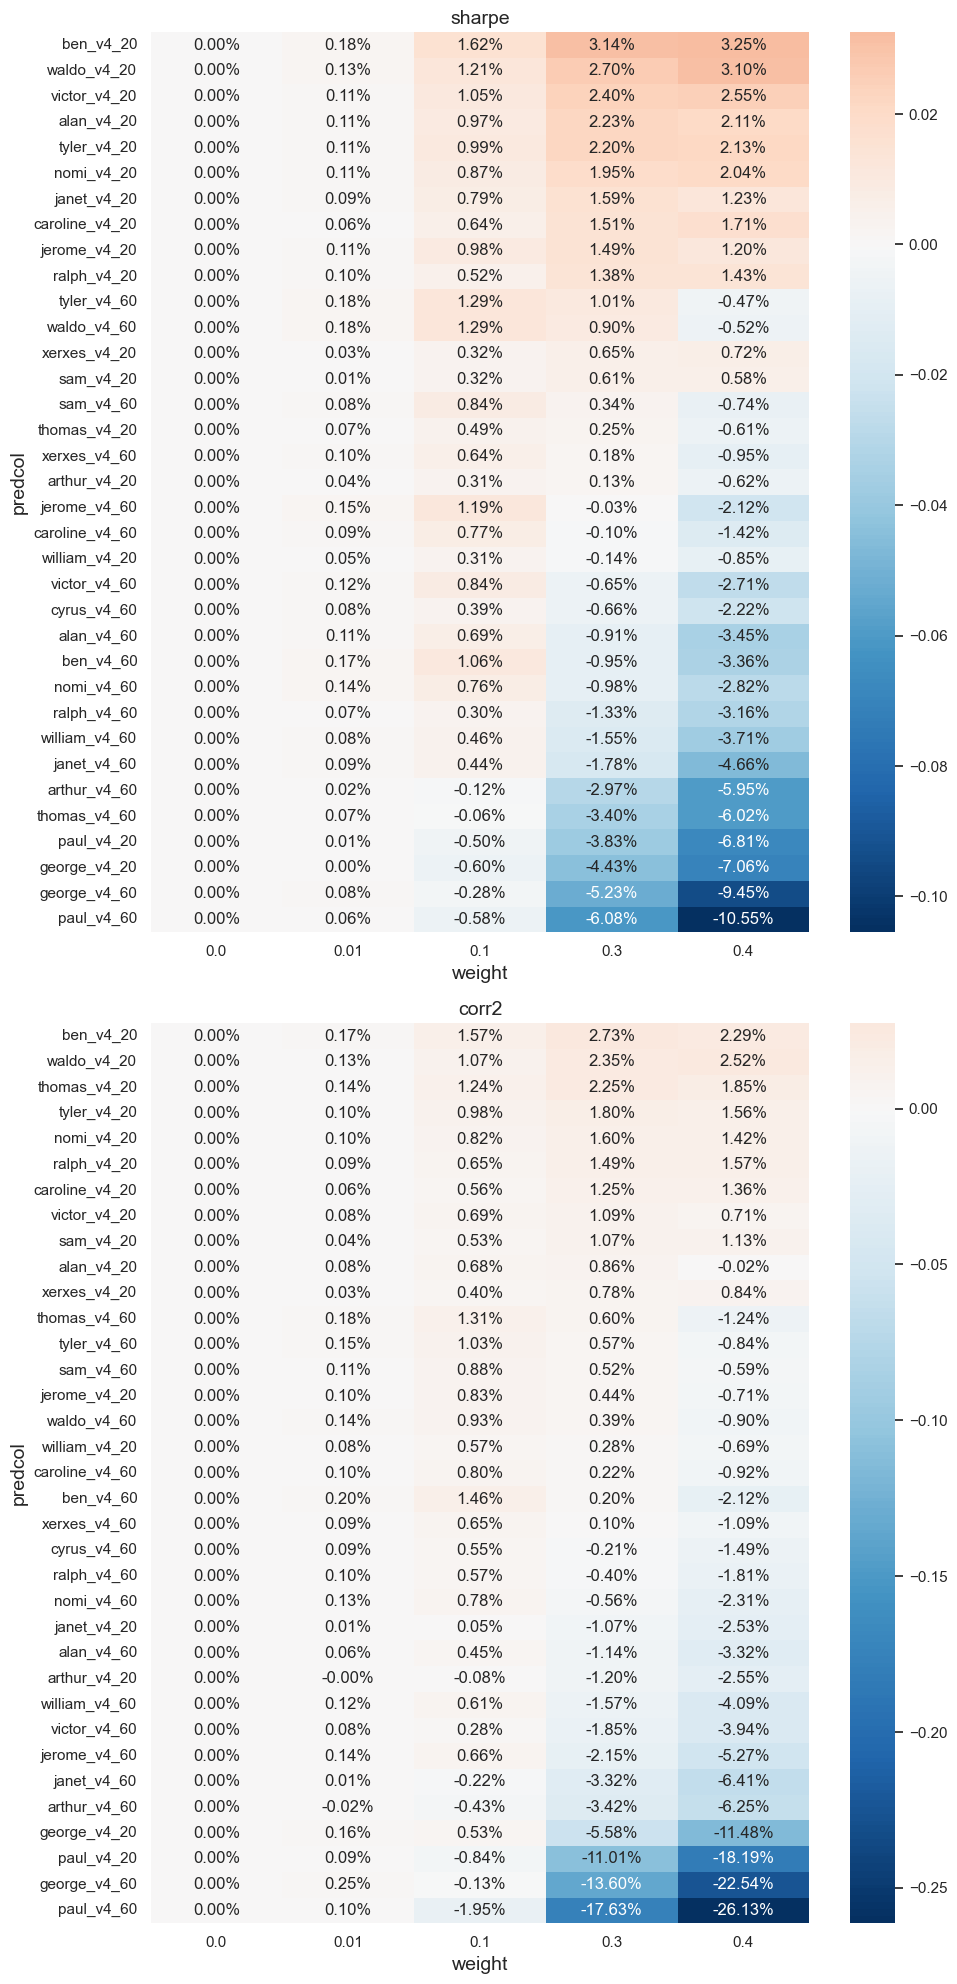

In [29]:
plot_hmap(metric_prop_diff_to_mat)

In [114]:
for metric in ["sharpe", "corr2"]:
    layout = go.Layout(
        width=800,
        height=600,
        title=f"Δ{metric}% when adding a predcol at different weights",
        xaxis_title="weights",
        yaxis_title=f"Δ{metric}%",
    )
    fig = (
        pd.DataFrame(
            metric_prop_diff_to_mat[metric]*100,
            index=PREDCOL_SHORTER_NAMES,
            columns=WTS[:,0],
        )
        .transpose()
        .iplot(
            kind='line',
            
            asFigure=True,
            layout=layout,
            
            
        )
    )
    fig.add_hline(y=0, line_dash="dash",
              annotation_text="Baseline with only cyrus", 
              annotation_position="bottom left",
              annotation_font_size=20,
              annotation_font_color="black",
    )
    fig.show()

## 5. Hand selecting 6 additional targets that seems to perform well on both corr2 and sharpe

Chosen ones `ben_20`, `waldo_20`, `caroline_20`, `tyler_20`, `nomi_20` and `victor_20`. For all of them we will use a **weight of 0.3**.

### 5.1 Predict weighted combination

#### 5.1.1 Combine all 3 cv val+test df as we are going to plot erawise predictions together

In [130]:
cv_valtest_dfs = []
for vt_dfs in cv_valpreds["cv_to_val_test_map"]:
    for split in ["val", "test"]:
        _df = vt_dfs[split].copy()
        _df.rename(
            columns={
                c: c[:-4]
                for c in _df.columns
                if c.startswith("pred_target_")
            },
            inplace=True,
        )
        cv_valtest_dfs.append(_df)
combined_test_df = pd.concat(objs=cv_valtest_dfs, axis=0,)
log.info(f"{combined_test_df.shape=}")
combined_test_df.head()

[2023-05-01 07:36:55]  combined_test_df.shape=(3328670, 84)


target  target_nomi_v4_20  target_nomi_v4_60   
id                                                               
n001f768affa1cc2     1.0                1.0               0.75  \
n002cc5b29f8705f     0.5                0.5               0.50   
n00361f031876c68     0.5                0.5               0.50   
n00385e672d049e6     0.0                0.0               0.25   
n00503d13b28d441     0.5                0.5               0.50   

                  target_tyler_v4_20  target_tyler_v4_60  target_victor_v4_20   
id                                                                              
n001f768affa1cc2                0.75                0.75                  1.0  \
n002cc5b29f8705f                0.25                0.50                  0.5   
n00361f031876c68                0.50                0.50                  0.5   
n00385e672d049e6                0.25                0.50                  0.0   
n00503d13b28d441                0.50                0.25                  0.5   

                  target_victor_v4_60  target_ralph_v4_20  target_ralph_v4_60   
id                                                                              
n001f768affa1cc2                 0.75                 1.0                0.75  \
n002cc5b29f8705f                 0.50                 0.5                0.50   
n00361f031876c68                 0.50                 0.5                0.50   
n00385e672d049e6                 0.25                 0.0                0.25   
n00503d13b28d441                 0.50                 0.5                0.50   

                  target_waldo_v4_20  ...  pred_target_william_v4_60   
id                                    ...                              
n001f768affa1cc2                 1.0  ...                   0.476133  \
n002cc5b29f8705f                 0.5  ...                   0.507437   
n00361f031876c68                 0.5  ...                   0.479478   
n00385e672d049e6                 0.0  ...                   0.498582   
n00503d13b28d441                 0.5  ...                   0.513035   

                  ensemble_allpreds_mean_cv0  ensemble_top8preds_mean_cv0   
id                                                                          
n001f768affa1cc2                         NaN                          NaN  \
n002cc5b29f8705f                         NaN                          NaN   
n00361f031876c68                         NaN                          NaN   
n00385e672d049e6                         NaN                          NaN   
n00503d13b28d441                         NaN                          NaN   

                  ensemble_cyrus_only_cv0  ensemble_allpreds_mean_cv1   
id                                                                      
n001f768affa1cc2                      NaN                         NaN  \
n002cc5b29f8705f                      NaN                         NaN   
n00361f031876c68                      NaN                         NaN   
n00385e672d049e6                      NaN                         NaN   
n00503d13b28d441                      NaN                         NaN   

                  ensemble_top8preds_mean_cv1  ensemble_cyrus_only_cv1   
id                                                                       
n001f768affa1cc2                          NaN                      NaN  \
n002cc5b29f8705f                          NaN                      NaN   
n00361f031876c68                          NaN                      NaN   
n00385e672d049e6                          NaN                      NaN   
n00503d13b28d441                          NaN                      NaN   

                  ensemble_allpreds_mean_cv2  ensemble_top8preds_mean_cv2   
id                                                                          
n001f768affa1cc2                         NaN                          NaN  \
n002cc5b29f8705f                         NaN                          NaN   
n00361f031876c68                   

In [131]:
# check with one of the targets that it's always present
log.info(f"{combined_test_df['pred_target_waldo_v4_20'].isna().sum()=}")
combined_test_df["pred_target_waldo_v4_20"].describe().to_frame().style.format("{:.2f}")

[2023-05-01 07:37:00]  combined_test_df['pred_target_waldo_v4_20'].isna().sum()=0


In [132]:
del cv_valtest_dfs
gc.collect()

51622

#### 5.1.2 Plot test eras in combined df

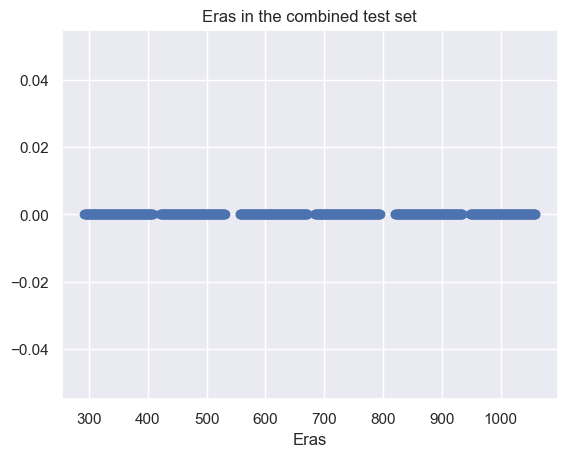

In [133]:
cmb_test_uniq_eras = combined_test_df[ERA_COL].unique()
plt.scatter(cmb_test_uniq_eras, y=[0]*len(cmb_test_uniq_eras))
plt.title("Eras in the combined test set")
plt.xlabel("Eras");

In [89]:
BASELINE_TGT_COL = "pred_target_cyrus_v4_20"

In [90]:
def predict_wtd_combination(df, paircols, wts, target_col=TARGET_COL, baseline_tgt_col=BASELINE_TGT_COL):
    ensmbl_cols = []
    pred_df = pd.DataFrame(index=df.index)
    for paircol in paircols:
        # add era col, baseline col and target col
        pred_df.loc[:, ERA_COL] = df[ERA_COL]
        pred_df.loc[:, baseline_tgt_col] = df[baseline_tgt_col]
        pred_df.loc[:, target_col] = df[target_col]
        # make wtd comb prediction
        pcols = [paircol, baseline_tgt_col]
        ensmbl_col = f"ens_{paircol}_wt{wts[0]}"
        pred_df.loc[:, ensmbl_col] = df[pcols].values @ wts
        ensmbl_cols.append(ensmbl_col)
    pred_df = pred_df[~pred_df[target_col].isna()]
    return pred_df, ensmbl_cols

In [99]:
wtd_cmb_pred_df, ensmbl_cols = predict_wtd_combination(
    df=combined_test_df,
    paircols=[
        "pred_target_ben_v4_20",
        "pred_target_waldo_v4_20",
        "pred_target_tyler_v4_20",
        "pred_target_nomi_v4_20",
        "pred_target_victor_v4_20",
        "pred_target_alan_v4_20",
    ],
    wts=np.array([0.3, 0.7]),
)

In [100]:
wtd_cmb_pred_df

era  pred_target_cyrus_v4_20  target_cyrus_v4_20   
id                                                                   
n001f768affa1cc2  820                 0.506688                1.00  \
n002cc5b29f8705f  820                 0.493007                0.50   
n00361f031876c68  820                 0.484418                0.50   
n00385e672d049e6  820                 0.487811                0.00   
n00503d13b28d441  820                 0.526851                0.75   
...               ...                      ...                 ...   
nffc14e08a58d0d3  531                 0.555518                0.50   
nffc628282dc8c05  531                 0.473636                0.75   
nffd0afc1826e574  531                 0.485911                0.50   
nffdbf67af822d8d  531                 0.501016                0.50   
nffe1d9fa9524443  531                 0.484750                0.50   

                  ens_pred_target_ben_v4_20_wt0.3   
id                                                  
n001f768affa1cc2                         0.502864  \
n002cc5b29f8705f                         0.493718   
n00361f031876c68                         0.485568   
n00385e672d049e6                         0.489010   
n00503d13b28d441                         0.526136   
...                                           ...   
nffc14e08a58d0d3                         0.555323   
nffc628282dc8c05                         0.471297   
nffd0afc1826e574                         0.490222   
nffdbf67af822d8d                         0.513561   
nffe1d9fa9524443                         0.493775   

                  ens_pred_target_waldo_v4_20_wt0.3   
id                                                    
n001f768affa1cc2                           0.505273  \
n002cc5b29f8705f                           0.496576   
n00361f031876c68                           0.485384   
n00385e672d049e6                           0.489252   
n00503d13b28d441                           0.529705   
...                                             ...   
nffc14e08a58d0d3                           0.558801   
nffc628282dc8c05                           0.476960   
nffd0afc1826e574                           0.495250   
nffdbf67af822d8d                           0.496014   
nffe1d9fa9524443                           0.487498   

                  ens_pred_target_tyler_v4_20_wt0.3   
id                                                    
n001f768affa1cc2                           0.506276  \
n002cc5b29f8705f                           0.494581   
n00361f031876c68                           0.488631   
n00385e672d049e6                           0.487170   
n00503d13b28d441                           0.525111   
...                                             ...   
nffc14e08a58d0d3                           0.554084   
nffc628282dc8c05                           0.472143   
nffd0afc1826e574                           0.492725   
nffdbf67af822d8d                           0.501760   
nffe1d9fa9524443                           0.490951   

                  ens_pred_target_nomi_v4_20_wt0.3   
id                                                   
n001f768affa1cc2                          0.503157  \
n002cc5b29f8705f                          0.491865   
n00361f031876c68                          0.485425   
n00385e672d049e6                          0.482890   
n00503d13b28d441                          0.528202   
...                                            ...   
nffc14e08a58d0d3                          0.559283   
nffc628282dc8c05                          0.471298   
nffd0afc1826e574                          0.491939   
nffdbf67af822d8d                          0.503709   
nffe1d9fa9524443                          0.484257   

                  ens_pred_target_victor_v4_20_wt0.3   
id                                                     
n001f768affa1cc2                            0.503624  \
n002cc5b29f8705f                            0.493385   
n00361f031876c68                            0.485657   
n0

In [101]:
wtd_cmb_pred_df.describe().transpose().style.format("{:.3f}")

['ens_pred_target_ben_v4_20_wt0.3', 'ens_pred_target_waldo_v4_20_wt0.3', 'ens_pred_target_tyler_v4_20_wt0.3', 'ens_pred_target_nomi_v4_20_wt0.3', 'ens_pred_target_victor_v4_20_wt0.3', 'ens_pred_target_alan_v4_20_wt0.3']


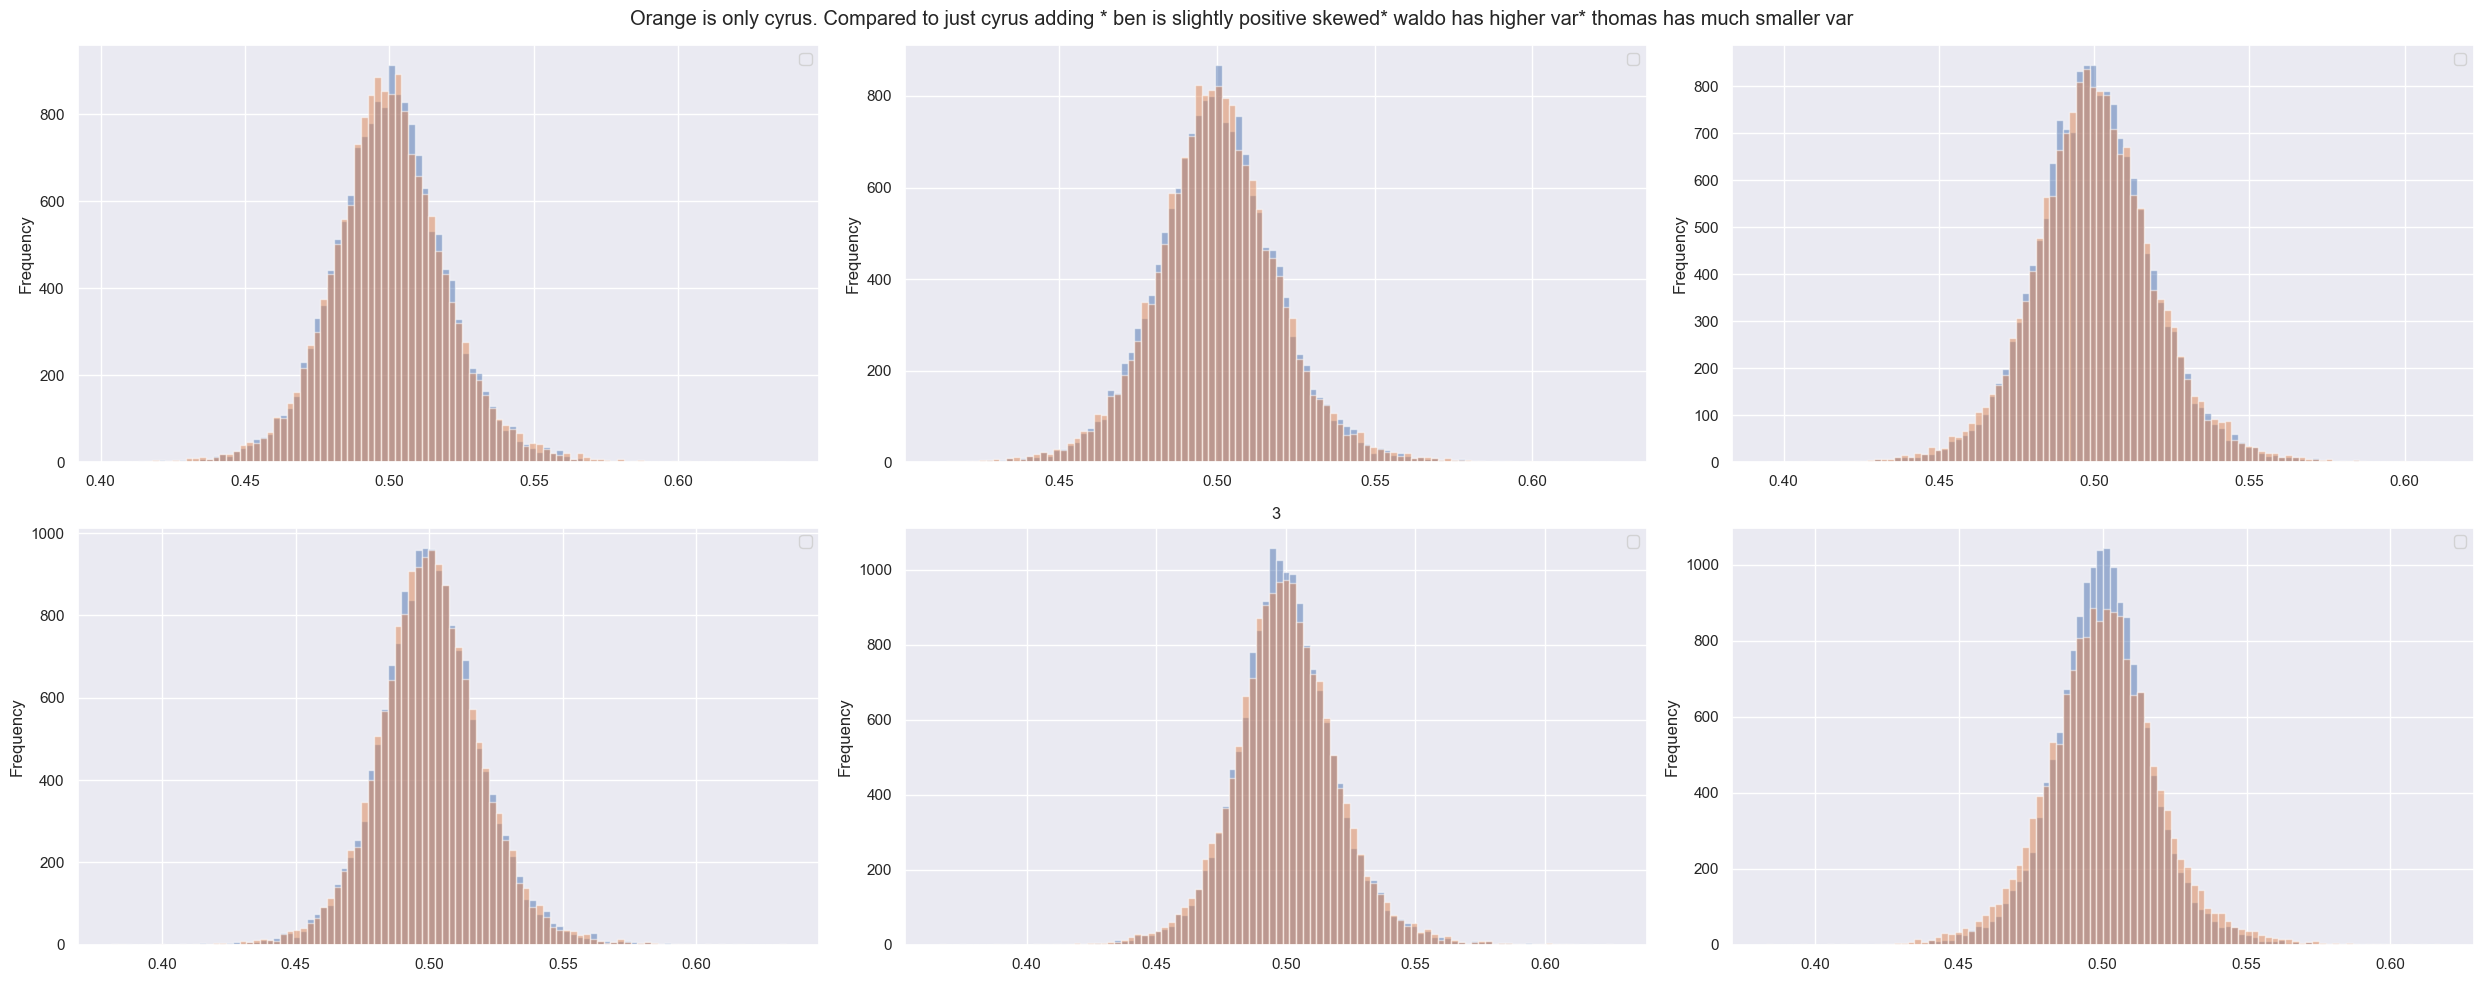

In [102]:
ens_cols = [c for c in wtd_cmb_pred_df.columns if c.startswith("ens")]
print(ens_cols)
fig, axes = plt.subplots(2, len(ens_cols)//2, figsize=(25,10))
for ax, c in zip(axes.flat, ens_cols):
    wtd_cmb_pred_df[[c, BASELINE_TGT_COL]].sample(frac=0.005).plot.hist(
        ax=ax,
        bins=100,
        alpha=0.5,
    )
    ax.legend([])
    ax.set_title(f"{c[33:]}")
plt.suptitle(
    "Orange is only cyrus. "
    "Compared to just cyrus adding "
    "* ben is slightly positive skewed"
    "* waldo has higher var"
    "* thomas has much smaller var"
);
plt.tight_layout()

In [ ]:
fig = wtd_cmb_pred_df[[c for c in wtd_cmb_pred_df if c not in {"era", "target_cyrus_v4_20"}]].sample(frac=0.005).iplot(
    kind="hist",
    bins=100,
    asFigure=True,
)
fig

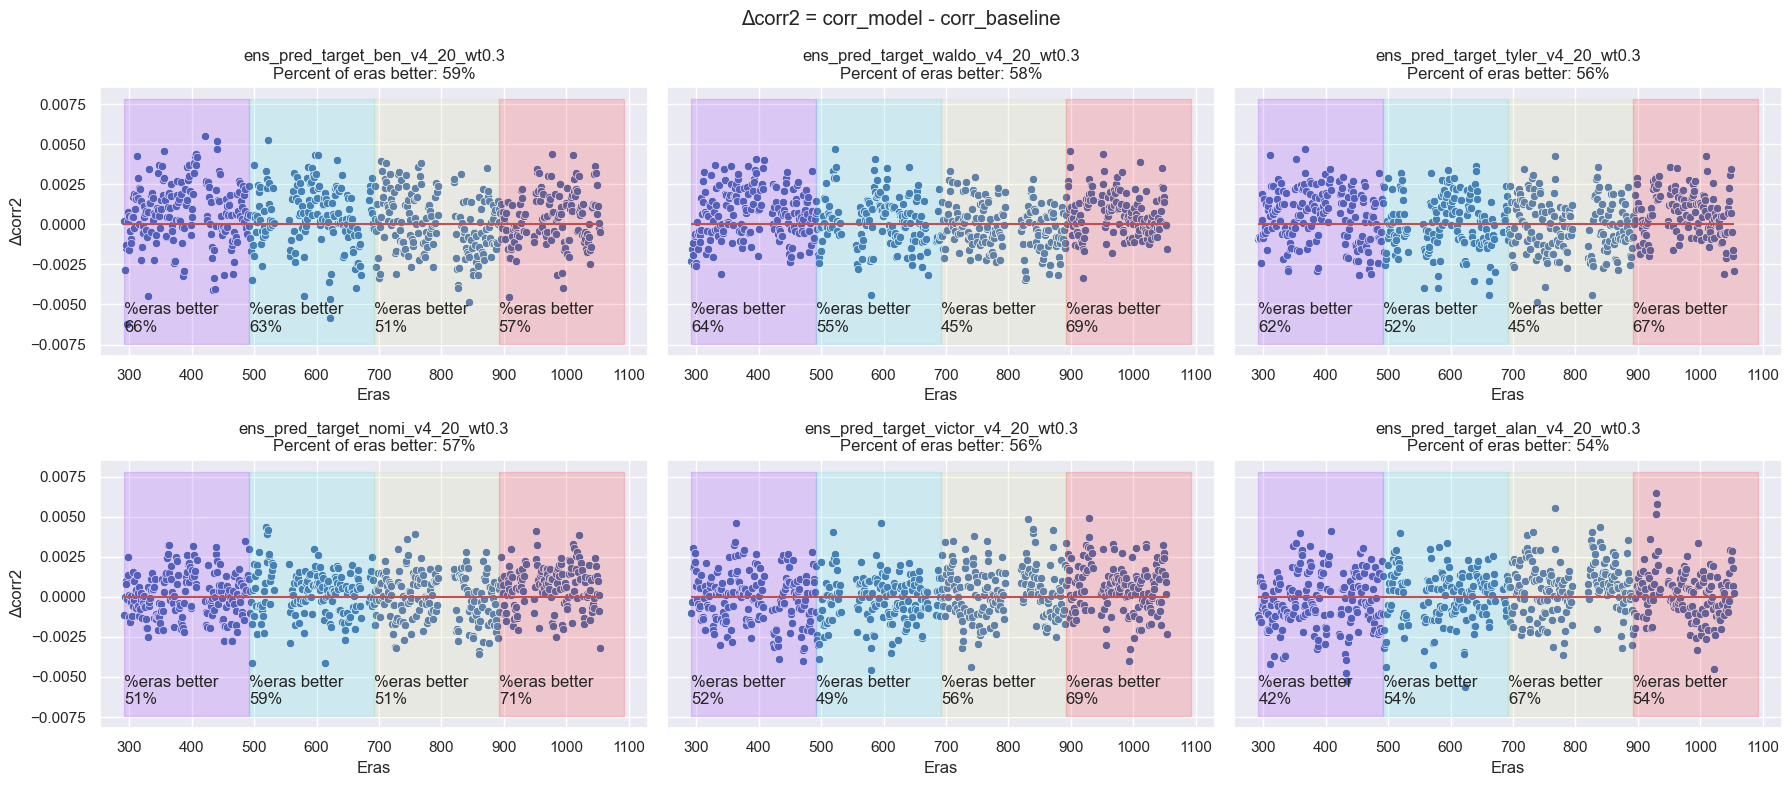

In [238]:
fig, summary_df = ut.compare_models_with_baseline(
    df=wtd_cmb_pred_df,
    predcols=ens_cols,
    baseline_col=BASELINE_TGT_COL,
    target_col=TARGET_COL,
)

In [239]:
summary_df.style.set_table_styles(ut.DF_STYLE).bar(subset=['Δcorr2%', "Δsharpe%"], color="lightblue")

### 5.2 Ensemble on the top 5 features based on `sharpe`
We will skip `alan_v4_20` as it only performs well in later eras.

- `cyrus_v4_20`
- `ben_v4_20`
- `waldo_v4_20`
- `tyler_v4_20`
- `victor_v4_20`
- `nomi_v4_20`

##### Remove nan target rows

In [176]:
cmb_test_no_na_df = combined_test_df.copy()
cmb_test_no_na_df = cmb_test_no_na_df[~cmb_test_no_na_df[TARGET_COL].isna()]

In [241]:
log.info(f"Train info: {cmb_test_no_na_df.shape=}, {cmb_test_no_na_df.era.nunique()=}, {cmb_test_no_na_df.era.min()=}, {cmb_test_no_na_df.era.max()=}")

[2023-05-01 09:50:06]  Train info: cmb_test_no_na_df.shape=(3303196, 84), cmb_test_no_na_df.era.nunique()=679, cmb_test_no_na_df.era.min()=292, cmb_test_no_na_df.era.max()=1054


In [411]:
chosen_predcols = [
    'pred_target_cyrus_v4_20',
    'pred_target_ben_v4_20',
    'pred_target_waldo_v4_20',
    'pred_target_tyler_v4_20',
    'pred_target_victor_v4_20',
    'pred_target_nomi_v4_20',
]
X_test = cmb_test_no_na_df[chosen_predcols]
target = cmb_test_no_na_df[TARGET_COL]
print(TARGET_COL)

target_cyrus_v4_20


In [412]:
gc.collect()

17059

In [413]:
# Linear regression: (X'X)^-1 X' y
weighting = np.linalg.inv(X_test.T@X_test)@X_test.T@target

In [414]:
ut.fmt_metrics_df(pd.DataFrame({"predcol": chosen_predcols, "weight": weighting}).set_index("predcol"))

#### 5.2.1 Regression overfits, simply set the weight of cyrus to 0.7 and redistribute 0.3 amongst the other predcols added.

In [415]:
reweighting = weighting.copy()
cyrus_wt = 0.7
reweighting[0] = cyrus_wt
reweighting[1:] = (1-cyrus_wt) /len(reweighting[1:])
ut.fmt_metrics_df(pd.DataFrame({"predcol": chosen_predcols, "weight": reweighting}).set_index("predcol"))

#### 5.2.2 In sample metrics by ensembling multiple targets

In [418]:
wtd_cmb_pred_df["pred_target_ens_multi"] = cmb_test_no_na_df[chosen_predcols].values @ reweighting

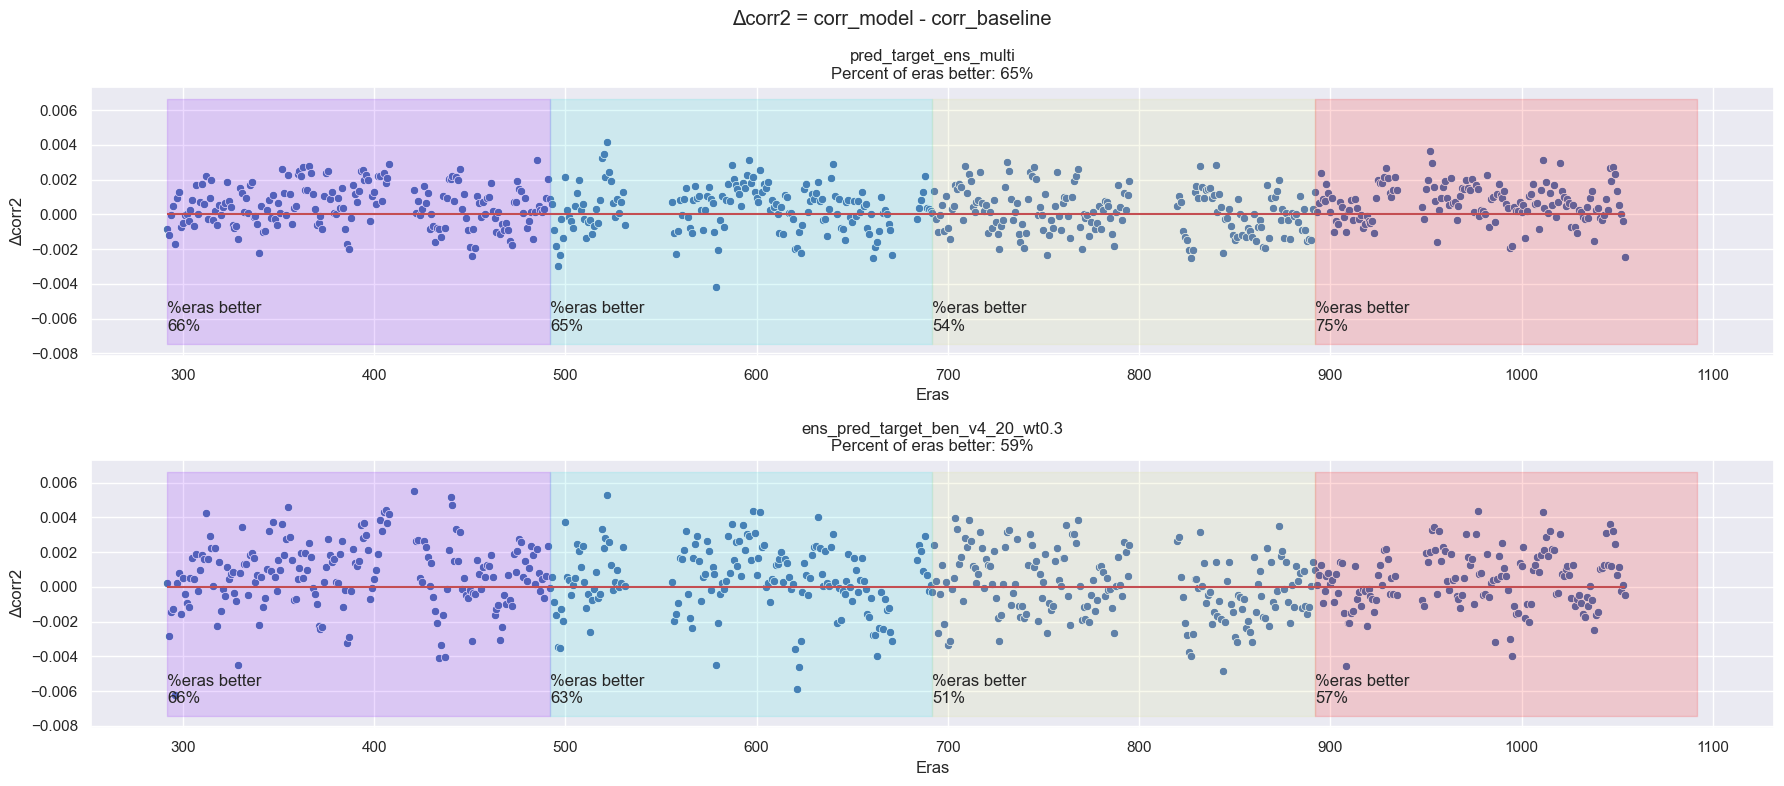

In [419]:
fig, summary_df = ut.compare_models_with_baseline(
    df=wtd_cmb_pred_df,
    predcols=["pred_target_ens_multi", "ens_pred_target_ben_v4_20_wt0.3"],
    baseline_col=BASELINE_TGT_COL,
    target_col=TARGET_COL,
)
display(summary_df.style.set_table_styles(ut.DF_STYLE).bar(subset=['Δcorr2%', "Δsharpe%"], color="lightblue"))

### 5.3 Ensemble with all targets

In [430]:
predcols = [c for c in cmb_test_no_na_df.columns if c.startswith("pred_target") and c!="pred_target_cyrus_v4_20"]
nother_targets = len(predcols)
print(f"{nother_targets=}")
predcols

nother_targets=35


['pred_target_arthur_v4_20',
 'pred_target_arthur_v4_60',
 'pred_target_thomas_v4_20',
 'pred_target_thomas_v4_60',
 'pred_target_cyrus_v4_60',
 'pred_target_caroline_v4_20',
 'pred_target_caroline_v4_60',
 'pred_target_sam_v4_20',
 'pred_target_sam_v4_60',
 'pred_target_xerxes_v4_20',
 'pred_target_xerxes_v4_60',
 'pred_target_nomi_v4_20',
 'pred_target_nomi_v4_60',
 'pred_target_tyler_v4_20',
 'pred_target_tyler_v4_60',
 'pred_target_victor_v4_20',
 'pred_target_victor_v4_60',
 'pred_target_ralph_v4_20',
 'pred_target_ralph_v4_60',
 'pred_target_waldo_v4_20',
 'pred_target_waldo_v4_60',
 'pred_target_jerome_v4_20',
 'pred_target_jerome_v4_60',
 'pred_target_janet_v4_20',
 'pred_target_janet_v4_60',
 'pred_target_ben_v4_20',
 'pred_target_ben_v4_60',
 'pred_target_alan_v4_20',
 'pred_target_alan_v4_60',
 'pred_target_paul_v4_20',
 'pred_target_paul_v4_60',
 'pred_target_george_v4_20',
 'pred_target_george_v4_60',
 'pred_target_william_v4_20',
 'pred_target_william_v4_60']

In [431]:
all_weighting = np.array([0.7] + [0.3/nother_targets]*nother_targets)
all_weighting

array([0.7       , 0.00857143, 0.00857143, 0.00857143, 0.00857143,
       0.00857143, 0.00857143, 0.00857143, 0.00857143, 0.00857143,
       0.00857143, 0.00857143, 0.00857143, 0.00857143, 0.00857143,
       0.00857143, 0.00857143, 0.00857143, 0.00857143, 0.00857143,
       0.00857143, 0.00857143, 0.00857143, 0.00857143, 0.00857143,
       0.00857143, 0.00857143, 0.00857143, 0.00857143, 0.00857143,
       0.00857143, 0.00857143, 0.00857143, 0.00857143, 0.00857143,
       0.00857143])

In [437]:
predcols_all = ["pred_target_cyrus_v4_20"] + predcols

In [432]:
wtd_cmb_pred_df["pred_target_ens_all"] = cmb_test_no_na_df[
   predcols_all
].values @ all_weighting

In [521]:
wtd_cmb_pred_df["pred_target_top8_mean"] = cmb_test_no_na_df[[
    "pred_target_cyrus_v4_20",
    "pred_target_ralph_v4_20",
    "pred_target_sam_v4_20",
    "pred_target_xerxes_v4_20",
    "pred_target_caroline_v4_20",
    "pred_target_waldo_v4_20",
    "pred_target_nomi_v4_20",
    "pred_target_tyler_v4_20",
]].values @ (np.ones((8,))/8.)

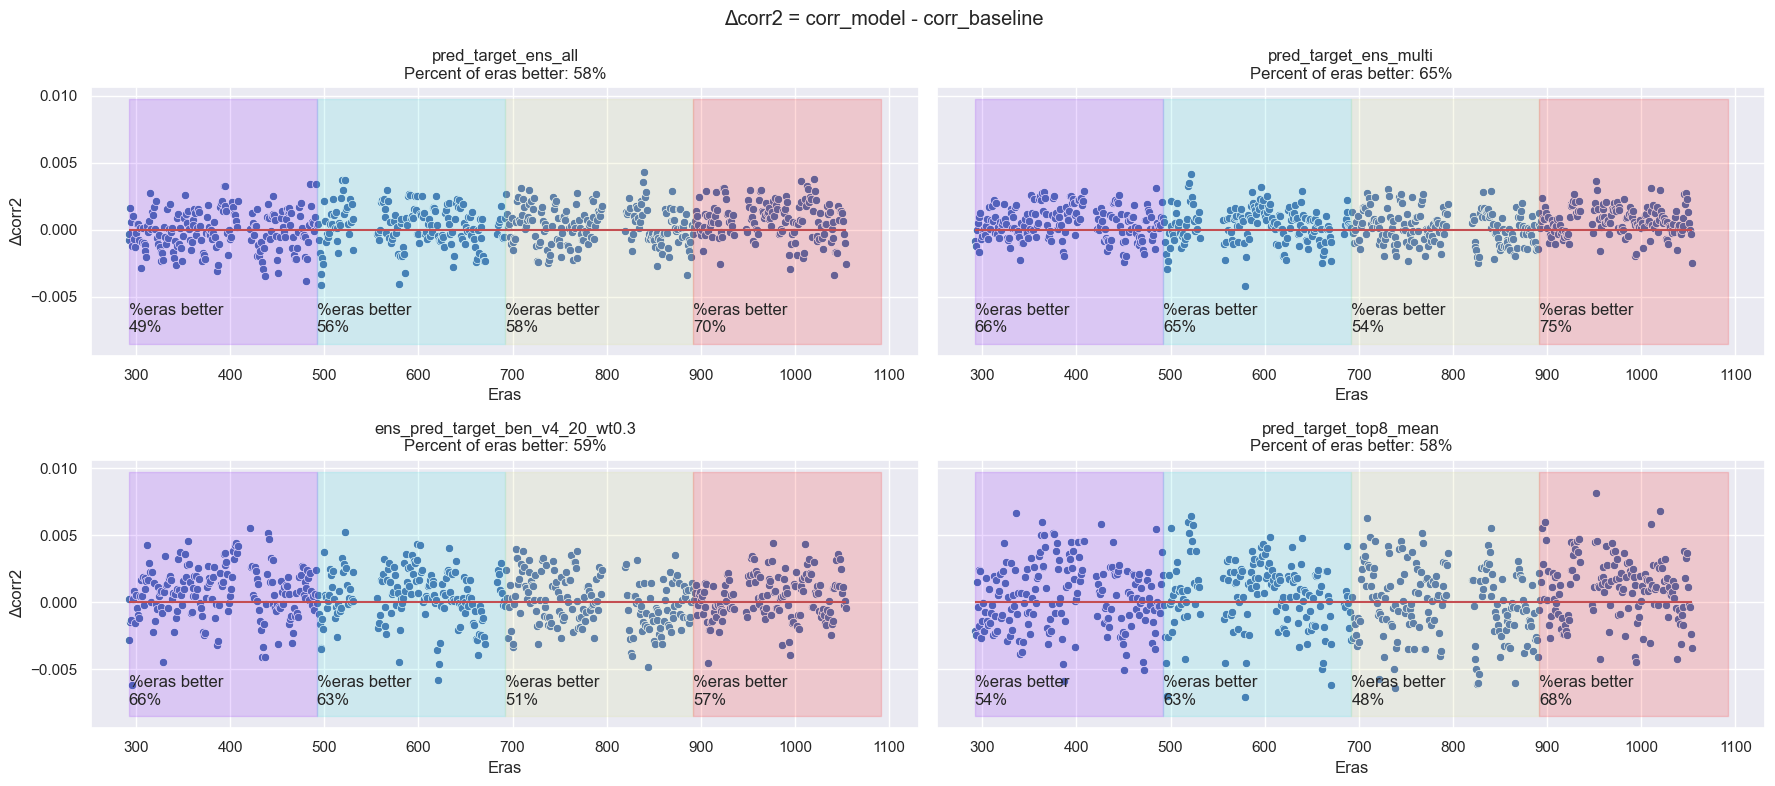

In [525]:
fig, summary_df = ut.compare_models_with_baseline(
    df=wtd_cmb_pred_df,
    predcols=["pred_target_ens_all", "pred_target_ens_multi", "ens_pred_target_ben_v4_20_wt0.3", "pred_target_top8_mean"],
    baseline_col=BASELINE_TGT_COL,
    target_col=TARGET_COL,
)
display(summary_df[["corr2", "sharpe", "Δcorr2%", "Δsharpe%"]].style.set_table_styles(ut.DF_STYLE).bar(subset=['Δcorr2%', "Δsharpe%"], color="lightblue"))

In [440]:
wtd_cmb_pred_df

era  pred_target_cyrus_v4_20  target_cyrus_v4_20   
id                                                                   
n001f768affa1cc2  820                 0.506688                1.00  \
n002cc5b29f8705f  820                 0.493007                0.50   
n00361f031876c68  820                 0.484418                0.50   
n00385e672d049e6  820                 0.487811                0.00   
n00503d13b28d441  820                 0.526851                0.75   
...               ...                      ...                 ...   
nffc14e08a58d0d3  531                 0.555518                0.50   
nffc628282dc8c05  531                 0.473636                0.75   
nffd0afc1826e574  531                 0.485911                0.50   
nffdbf67af822d8d  531                 0.501016                0.50   
nffe1d9fa9524443  531                 0.484750                0.50   

                  ens_pred_target_ben_v4_20_wt0.3   
id                                                  
n001f768affa1cc2                         0.502864  \
n002cc5b29f8705f                         0.493718   
n00361f031876c68                         0.485568   
n00385e672d049e6                         0.489010   
n00503d13b28d441                         0.526136   
...                                           ...   
nffc14e08a58d0d3                         0.555323   
nffc628282dc8c05                         0.471297   
nffd0afc1826e574                         0.490222   
nffdbf67af822d8d                         0.513561   
nffe1d9fa9524443                         0.493775   

                  ens_pred_target_waldo_v4_20_wt0.3   
id                                                    
n001f768affa1cc2                           0.505273  \
n002cc5b29f8705f                           0.496576   
n00361f031876c68                           0.485384   
n00385e672d049e6                           0.489252   
n00503d13b28d441                           0.529705   
...                                             ...   
nffc14e08a58d0d3                           0.558801   
nffc628282dc8c05                           0.476960   
nffd0afc1826e574                           0.495250   
nffdbf67af822d8d                           0.496014   
nffe1d9fa9524443                           0.487498   

                  ens_pred_target_tyler_v4_20_wt0.3   
id                                                    
n001f768affa1cc2                           0.506276  \
n002cc5b29f8705f                           0.494581   
n00361f031876c68                           0.488631   
n00385e672d049e6                           0.487170   
n00503d13b28d441                           0.525111   
...                                             ...   
nffc14e08a58d0d3                           0.554084   
nffc628282dc8c05                           0.472143   
nffd0afc1826e574                           0.492725   
nffdbf67af822d8d                           0.501760   
nffe1d9fa9524443                           0.490951   

                  ens_pred_target_nomi_v4_20_wt0.3   
id                                                   
n001f768affa1cc2                          0.503157  \
n002cc5b29f8705f                          0.491865   
n00361f031876c68                          0.485425   
n00385e672d049e6                          0.482890   
n00503d13b28d441                          0.528202   
...                                            ...   
nffc14e08a58d0d3                          0.559283   
nffc628282dc8c05                          0.471298   
nffd0afc1826e574                          0.491939   
nffdbf67af822d8d                          0.503709   
nffe1d9fa9524443                          0.484257   

                  ens_pred_target_victor_v4_20_wt0.3   
id                                                     
n001f768affa1cc2                            0.503624  \
n002cc5b29f8705f                            0.493385   
n00361f031876c68                            0.485657   
n0

In [473]:
pred_corr_df = cmb_test_no_na_df[predcols_all].corr()

In [474]:
pred_corr_df.index = [c[len('pred_target_'):]for c in pred_corr_df.index]
pred_corr_df.columns = [c[len('pred_target_'):]for c in pred_corr_df.columns]

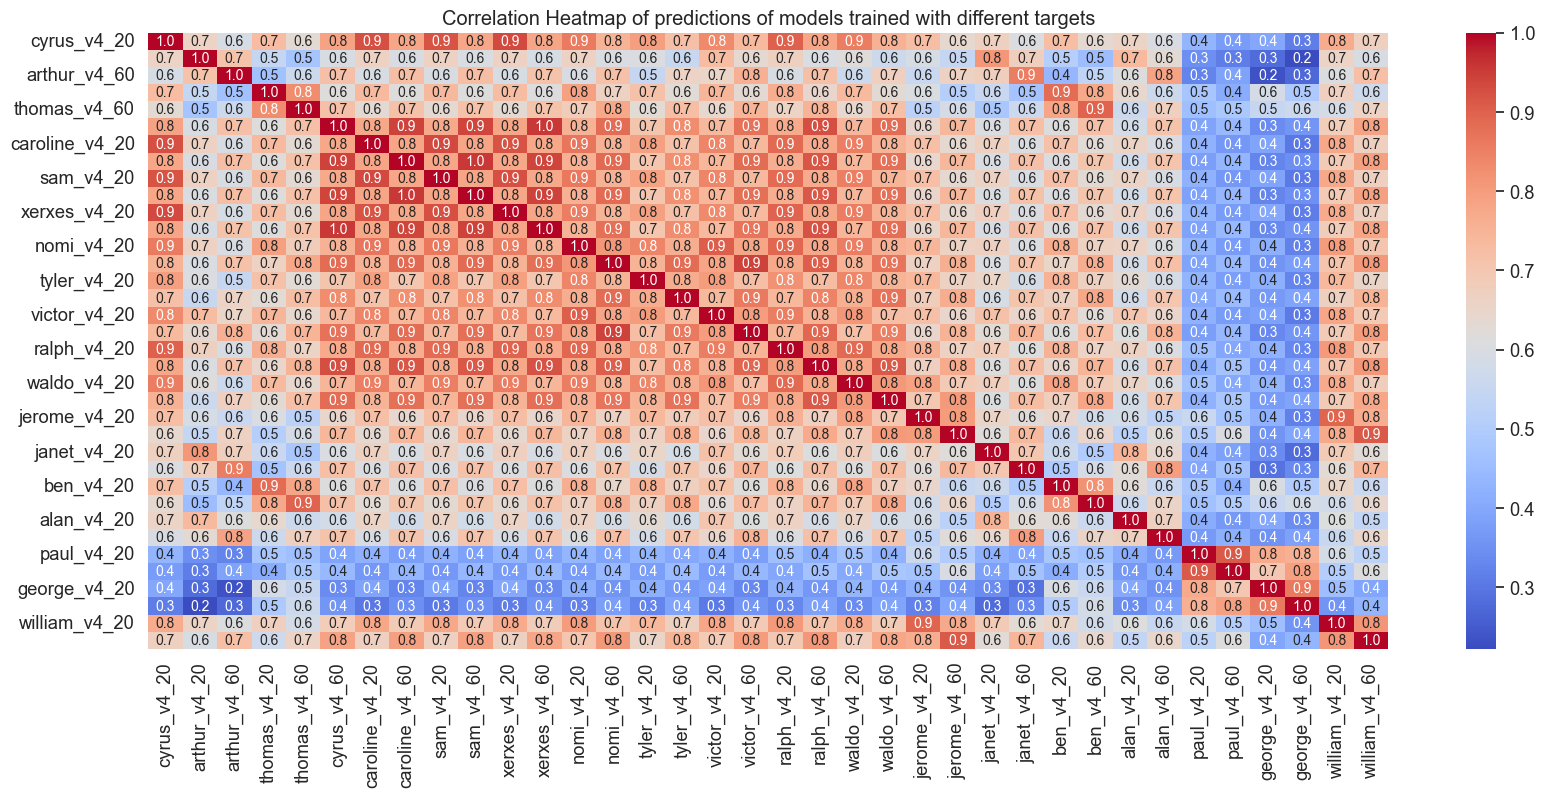

In [479]:
sns.set(font_scale=1.2)
plt.figure(figsize=(20,8))
sns.heatmap(pred_corr_df, annot=True, cmap='coolwarm',  fmt='.1f', annot_kws={'size': 10}, )
plt.title('Correlation Heatmap of predictions of models trained with different targets');
plt.show()

In [505]:
sort_ix = pred_corr_df['cyrus_v4_20'].values.argsort()[::-1]
cyrus_corrs = pred_corr_df['cyrus_v4_20'].values[sort_ix]
cols = pred_corr_df.index[sort_ix]

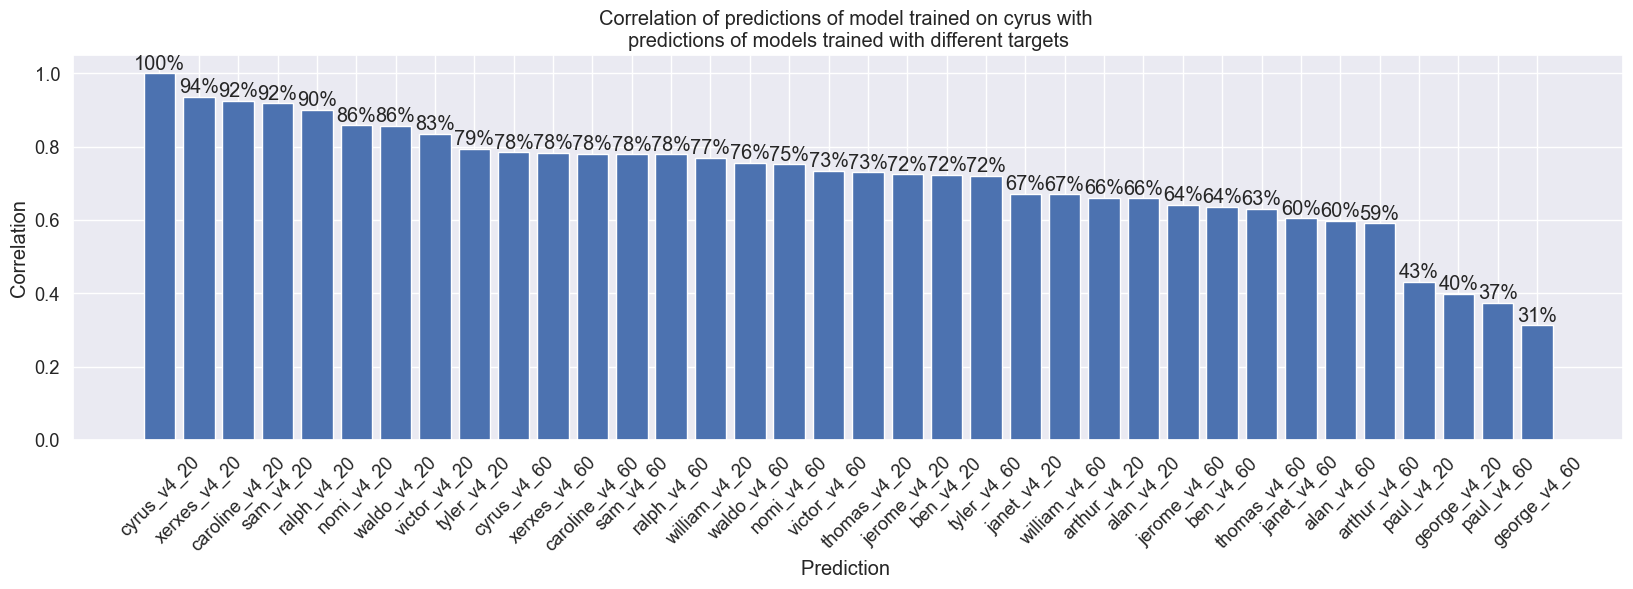

In [513]:
# create line plot with annotations
plt.figure(figsize=(20,5))
plt.bar(cols, cyrus_corrs)
for x, y in zip(cols, cyrus_corrs):
    plt.text(x, y, f"{y:.0%}", ha='center', va='bottom')

# set plot title and axis labels
plt.xticks(rotation=45)
plt.title('Correlation of predictions of model trained on cyrus with \npredictions of models trained with different targets')
plt.xlabel('Prediction ')
plt.ylabel('Correlation');

# display the plot

<Axes: >

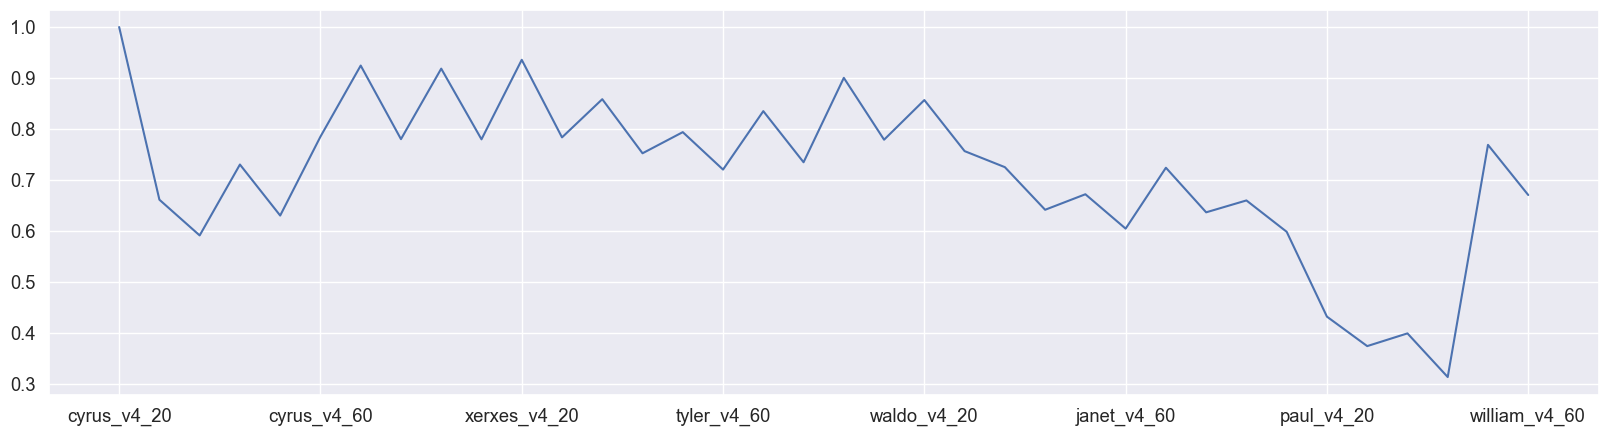

In [490]:

pred_corr_df.iloc[0].plot(kind="line")